## Reveal AI final project

- *Will test multiple models in this notebook*
- resnet50
-


In [ ]:
# mount drive first
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:



!apt-get install -y p7zip-full
DRIVE_ZIP_PATH_1 = '/content/drive/MyDrive/Colab Notebooks/RevealAI/test.7z'
DRIVE_ZIP_PATH_2 = '/content/drive/MyDrive/Colab Notebooks/RevealAI/train.7z'
DRIVE_ZIP_PATH_3 = '/content/drive/MyDrive/Colab Notebooks/RevealAI/validation.7z'


# # Local temporary disk destination
LOCAL_DESTINATION = '/content/'

# # Execute the copy command

!cp "{DRIVE_ZIP_PATH_1}" "{LOCAL_DESTINATION}"
!cp "{DRIVE_ZIP_PATH_2}" "{LOCAL_DESTINATION}"
!cp "{DRIVE_ZIP_PATH_3}" "{LOCAL_DESTINATION}"

print(f" Copied data to local Colab disk.")
# # Path to the ZIP file on the local disk

LOCAL_ZIP_PATH_1 = '/content/test.7z'
LOCAL_ZIP_PATH_2 = '/content/train.7z'
LOCAL_ZIP_PATH_3 = '/content/validation.7z'

# # Execute the unzip command
# # -q: quiet (less terminal output)
# # -d /content/: extract contents to the /content/ directory

!7z x "{LOCAL_ZIP_PATH_1}" -o/content/
!7z x "{LOCAL_ZIP_PATH_2}" -o/content/
!7z x "{LOCAL_ZIP_PATH_3}" -o/content/
print(" Unzipping complete! Your data is now fast to access.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
 Copied data to local Colab disk.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 714238854 bytes (682 MiB)

Extracting archive: /content/test.7z
--
Path = /content/test.7z
Type = 7z
Physical Size = 714238854
Headers Size = 103910
Method = LZMA:23
Solid = +
Blocks = 1

  0%      0% - test/ai/000_biggan_00130.jpg                                     1% 50 - test/ai/054_biggan_00066.jpg            

In [ ]:
# !ls test

In [ ]:
!pip install timm
!pip install transformers timm ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
#!ls

In [ ]:
# u have to get ride of the empty files or the model wont run
import os

folders = [
    "/content/train/real",
    "/content/test/ai",
    "/content/test/real",
    "/content/validation/ai",
    "/content/validation/real"
]
for folder in folders:
  for f in os.listdir(folder):
    path = os.path.join(folder, f)
    if os.path.isfile(path) and f.lower().endswith(('.jpg', '.jpeg')):
        if os.path.getsize(path) == 0:
            os.remove(path)
            print(f"Deleted empty file: {path}")

Deleted empty file: /content/train/real/n03476684_11841.JPEG
Deleted empty file: /content/train/real/n03461385_55558.JPEG
Deleted empty file: /content/train/real/n03483316_46638.JPEG
Deleted empty file: /content/train/real/n03492542_10748.JPEG
Deleted empty file: /content/train/real/n03476684_19139.JPEG
Deleted empty file: /content/train/real/n03445777_4042.JPEG
Deleted empty file: /content/train/real/n03482405_6412.JPEG
Deleted empty file: /content/train/real/n03450230_7148.JPEG
Deleted empty file: /content/train/real/n03461385_52244.JPEG
Deleted empty file: /content/train/real/n03478589_16121.JPEG
Deleted empty file: /content/train/real/n03445924_872.JPEG
Deleted empty file: /content/train/real/n03492542_25135.JPEG
Deleted empty file: /content/train/real/n03450230_3139.JPEG
Deleted empty file: /content/train/real/n03485794_36524.JPEG
Deleted empty file: /content/train/real/n03459775_5401.JPEG
Deleted empty file: /content/train/real/n03492542_32611.JPEG
Deleted empty file: /content/tr

In [ ]:
# imports
import os, sys,torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
import torch
import torch.nn.functional as F
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

In [ ]:
size_check = {}
# verify that the images are the same size or not
# print(os.listdir('1_fake')[0:10])
for img in os.listdir('/content/train/ai'):
    if '.ipynb_checkpoints' == img:
        continue
    images=Image.open('/content/train/ai/'+img)
    # print(images.size)
    if images.size in size_check:
        size_check[images.size] += 1
    else:
        size_check[images.size] = 1
# sizes are not the same
print(list(size_check.items())[0:10])


[((256, 256), 6300), ((512, 512), 6301), ((128, 128), 2100), ((1024, 1024), 2099)]


In [ ]:
# Resize images for convnext
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# Same transforms as your training
tf_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

tf_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/train', transform=tf_train)
val_dataset   = datasets.ImageFolder('/content/validation', transform=tf_eval)
test_dataset  = datasets.ImageFolder('/content/test', transform=tf_eval)

print(f"Classes: {train_dataset.classes}")
print(f"Total images: {len(train_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Classes: ['ai', 'real']
Total images: 33550


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Model Convnext Tiny Model

In [ ]:

model = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print("Model ready on device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Model ready on device: cuda


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
for epoch in range(10):

    # -------------------------
    # TRAINING
    # -------------------------
    model.train()
    train_total, train_correct, train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)


    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    # -------------------------
    # LOGGING
    # -------------------------
    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)

Epoch 1
  Train Loss: 0.2358 | Train Acc: 89.55%
  Val   Loss: 0.0963 | Val   Acc: 96.26%
--------------------------------------------------
Epoch 2
  Train Loss: 0.0587 | Train Acc: 97.79%
  Val   Loss: 0.1045 | Val   Acc: 96.19%
--------------------------------------------------
Epoch 3
  Train Loss: 0.0322 | Train Acc: 98.86%
  Val   Loss: 0.0798 | Val   Acc: 97.67%
--------------------------------------------------
Epoch 4
  Train Loss: 0.0230 | Train Acc: 99.19%
  Val   Loss: 0.0732 | Val   Acc: 97.53%
--------------------------------------------------
Epoch 5
  Train Loss: 0.0243 | Train Acc: 99.12%
  Val   Loss: 0.0840 | Val   Acc: 97.26%
--------------------------------------------------
Epoch 6
  Train Loss: 0.0156 | Train Acc: 99.45%
  Val   Loss: 0.0789 | Val   Acc: 97.58%
--------------------------------------------------
Epoch 7
  Train Loss: 0.0173 | Train Acc: 99.39%
  Val   Loss: 0.0736 | Val   Acc: 97.86%
--------------------------------------------------
Epoch 8
  Tra

Predicted class: ai


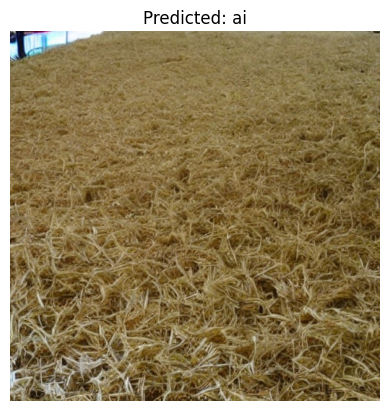

In [ ]:
import random

# pick random image from test/ai
folder = "/content/test/ai"
img_name = random.choice(os.listdir(folder))
img_path = folder + "/" + img_name

# same transform as eval
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(x).argmax(1).item()

label_names = train_dataset.classes  # ['ai', 'real']

print("Predicted class:", label_names[pred])

plt.imshow(img)
plt.title(f"Predicted: {label_names[pred]}")
plt.axis("off")
plt.show()

## Model Vision Transformer

In [ ]:

model = timm.create_model('vit_large_patch14_224', pretrained=False, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print("Model ready on device:", device)

Model ready on device: cuda


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):

    # -------------------------
    # TRAINING
    # -------------------------
    model.train()
    train_total, train_correct, train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)


    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    # -------------------------
    # LOGGING
    # -------------------------
    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)

Epoch 1
  Train Loss: 0.7450 | Train Acc: 51.58%
  Val   Loss: 0.6822 | Val   Acc: 55.32%
--------------------------------------------------
Epoch 2
  Train Loss: 0.6548 | Train Acc: 60.19%
  Val   Loss: 0.6271 | Val   Acc: 64.17%
--------------------------------------------------
Epoch 3
  Train Loss: 0.6056 | Train Acc: 66.34%
  Val   Loss: 0.5909 | Val   Acc: 68.12%
--------------------------------------------------
Epoch 4
  Train Loss: 0.5775 | Train Acc: 69.13%
  Val   Loss: 0.5785 | Val   Acc: 69.10%
--------------------------------------------------
Epoch 5
  Train Loss: 0.5452 | Train Acc: 71.69%
  Val   Loss: 0.5335 | Val   Acc: 73.09%
--------------------------------------------------
Epoch 6
  Train Loss: 0.4970 | Train Acc: 75.74%
  Val   Loss: 0.5654 | Val   Acc: 71.63%
--------------------------------------------------
Epoch 7
  Train Loss: 0.4735 | Train Acc: 77.14%
  Val   Loss: 0.5931 | Val   Acc: 71.13%
--------------------------------------------------
Epoch 8
  Tra

Predicted class: real


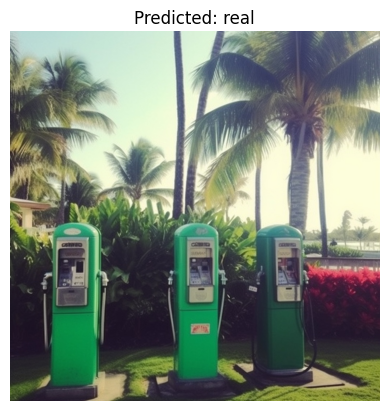

In [24]:
import random

# pick random image from test/ai
folder = "/content/test/ai"
img_name = random.choice(os.listdir(folder))
img_path = folder + "/" + img_name

# same transform as eval
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(x).argmax(1).item()

label_names = train_dataset.classes  # ['ai', 'real']

print("Predicted class:", label_names[pred])

plt.imshow(img)
plt.title(f"Predicted: {label_names[pred]}")
plt.axis("off")
plt.show()

## Model Resnet50

In [25]:

model = timm.create_model('resnet50', pretrained=True, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print("Model ready on device:", device)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model ready on device: cuda


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):

    # -------------------------
    # TRAINING
    # -------------------------
    model.train()
    train_total, train_correct, train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)


    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    # -------------------------
    # LOGGING
    # -------------------------
    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)

Epoch 1
  Train Loss: 0.4268 | Train Acc: 79.71%
  Val   Loss: 0.2663 | Val   Acc: 88.70%
--------------------------------------------------
Epoch 2
  Train Loss: 0.1811 | Train Acc: 92.75%
  Val   Loss: 0.1660 | Val   Acc: 93.45%
--------------------------------------------------
Epoch 3
  Train Loss: 0.1032 | Train Acc: 96.26%
  Val   Loss: 0.1521 | Val   Acc: 94.22%
--------------------------------------------------
Epoch 4
  Train Loss: 0.0605 | Train Acc: 97.93%
  Val   Loss: 0.1427 | Val   Acc: 95.02%
--------------------------------------------------
Epoch 5
  Train Loss: 0.0360 | Train Acc: 98.88%
  Val   Loss: 0.1559 | Val   Acc: 94.82%
--------------------------------------------------
Epoch 6
  Train Loss: 0.0245 | Train Acc: 99.26%
  Val   Loss: 0.1444 | Val   Acc: 95.16%
--------------------------------------------------
Epoch 7
  Train Loss: 0.0135 | Train Acc: 99.62%
  Val   Loss: 0.1626 | Val   Acc: 95.01%
--------------------------------------------------
Epoch 8
  Tra

Predicted class: ai


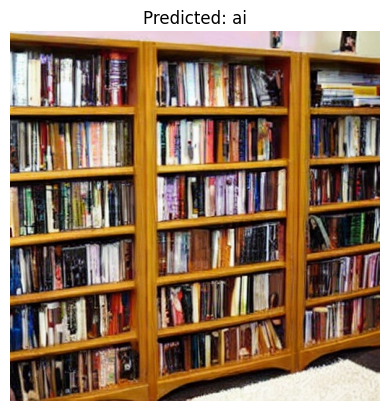

In [28]:
import random

# pick random image from test/ai
folder = "/content/test/ai"
img_name = random.choice(os.listdir(folder))
img_path = folder + "/" + img_name

# same transform as eval
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(x).argmax(1).item()

label_names = train_dataset.classes  # ['ai', 'real']

print("Predicted class:", label_names[pred])

plt.imshow(img)
plt.title(f"Predicted: {label_names[pred]}")
plt.axis("off")
plt.show()

## Model ShuffleNetV2

In [29]:


num_classes = 2
model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(1024, num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Model ready on device:", device)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 216MB/s]

Model ready on device: cuda


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):

    # -------------------------
    # TRAINING
    # -------------------------
    model.train()
    train_total, train_correct, train_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)


    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    # -------------------------
    # LOGGING
    # -------------------------
    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)

Epoch 1
  Train Loss: 0.4919 | Train Acc: 79.21%
  Val   Loss: 0.3326 | Val   Acc: 86.32%
--------------------------------------------------
Epoch 2
  Train Loss: 0.2679 | Train Acc: 88.62%
  Val   Loss: 0.2376 | Val   Acc: 89.90%
--------------------------------------------------
Epoch 3
  Train Loss: 0.1866 | Train Acc: 92.53%
  Val   Loss: 0.2017 | Val   Acc: 92.02%
--------------------------------------------------
Epoch 4
  Train Loss: 0.1424 | Train Acc: 94.33%
  Val   Loss: 0.1878 | Val   Acc: 92.72%
--------------------------------------------------
Epoch 5
  Train Loss: 0.1081 | Train Acc: 96.00%
  Val   Loss: 0.1856 | Val   Acc: 93.06%
--------------------------------------------------
Epoch 6
  Train Loss: 0.0846 | Train Acc: 96.97%
  Val   Loss: 0.2172 | Val   Acc: 92.62%
--------------------------------------------------
Epoch 7
  Train Loss: 0.0672 | Train Acc: 97.56%
  Val   Loss: 0.1936 | Val   Acc: 93.23%
--------------------------------------------------
Epoch 8
  Tra

In [33]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

print("Test Accuracy:", 100 * test_correct / test_total)

Test Accuracy: 92.50034785028524


Random test image: VQDM_1000_200_00_075_vqdm_00068.jpg
Predicted class: real


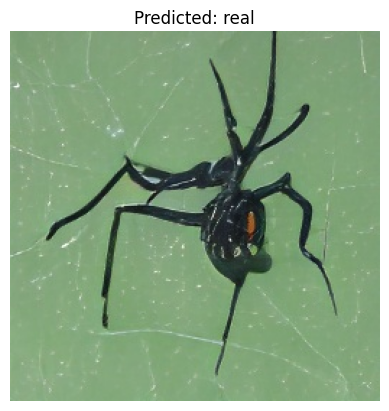

In [34]:


# Folder to sample from
folder = "/content/test/ai"
img_name = random.choice(os.listdir(folder))
img_path = folder + "/" + img_name

# Same transform as eval
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load + preprocess
img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    pred = model(x).argmax(1).item()

label_names = train_dataset.classes  # ['ai', 'real']

print("Random test image:", img_name)
print("Predicted class:", label_names[pred])

plt.imshow(img)
plt.title(f"Predicted: {label_names[pred]}")
plt.axis("off")
plt.show()

## CLIP VIT